# Data Visualizations

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
from glob import glob

def visualize_multiple_csvs_as_video(csv_folder, output_video_path='intersection.mp4', interval_ms=100, max_frames=None):
    all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))

    if not all_csvs:
        print("No CSV files found.")
        return

    df = pd.concat([pd.read_csv(csv_path) for csv_path in all_csvs])
    df = df.sort_values(by='TIMESTAMP')

    # Normalize track IDs to assign each car a unique color
    track_ids = df['TRACK_ID'].unique()
    colors = {track_id: plt.cm.tab20(i % 20) for i, track_id in enumerate(track_ids)}

    # Group by timestamp
    timestamps = sorted(df['TIMESTAMP'].unique())
    if max_frames is not None:
        timestamps = timestamps[:max_frames]

    grouped = df.groupby('TIMESTAMP')

    # Setup plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
    ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
    ax.set_aspect('equal')
    
    def init():
        return []

    def update(frame_idx):
        ts = timestamps[frame_idx]
        ax.clear()
        ax.set_xlim(df['X'].min() - 10, df['X'].max() + 10)
        ax.set_ylim(df['Y'].min() - 10, df['Y'].max() + 10)
        ax.set_title(f"Time: {ts:.1f}s")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_aspect('equal')

        road_width = 50
        ax.add_patch(plt.Rectangle((df['X'].min() - 20, -road_width / 2),
                                (df['X'].max() - df['X'].min()) + 40,
                                road_width, color='lightgray', zorder=0))
        ax.add_patch(plt.Rectangle((-road_width / 2, df['Y'].min() - 20),
                                road_width,
                                (df['Y'].max() - df['Y'].min()) + 40,
                                color='lightgray', zorder=0))

        if ts not in grouped.groups:
            return []

        frame_df = grouped.get_group(ts)

        # Draw vehicles
        for _, row in frame_df.iterrows():
            x = float(row['X'])
            y = float(row['Y'])
            track_id = row['TRACK_ID']
            yaw_deg = float(row['yaw'])             
            speed = float(row['speed'])
            color = colors.get(track_id, 'gray')

            # Heading for arrow (correct as is)
            heading_arrow = np.deg2rad(yaw_deg + 90)

            # Vehicle rotation (flipped horizontally)
            heading_rect = -heading_arrow

            length = 4
            width = 2
            dx = -length / 2
            dy = -width / 2

            rect = plt.Rectangle((x + dx, y + dy), length, width,
                                color=color, zorder=1)
            transform = plt.matplotlib.transforms.Affine2D().rotate_around(x, y, heading_rect) + ax.transData
            rect.set_transform(transform)
            ax.add_patch(rect)

            arrow_length = min(speed * 0.4, 10)
            ax.arrow(x, y,
                    -arrow_length * np.cos(heading_arrow),
                    arrow_length * np.sin(heading_arrow),
                    head_width=0.7,
                    head_length=1.0,
                    fc='black',
                    ec='black',
                    zorder=2)

            ax.text(x, y + 2.5, str(track_id), fontsize=6, ha='center', zorder=3)

        return []


    ani = animation.FuncAnimation(fig, update, frames=len(timestamps), init_func=init, interval=interval_ms, blit=False)
    ani.save(output_video_path, writer='ffmpeg', fps=1000 // interval_ms)
    print(f"Video saved to {output_video_path}")


Video saved to simple_separate_10m_intersection.mp4


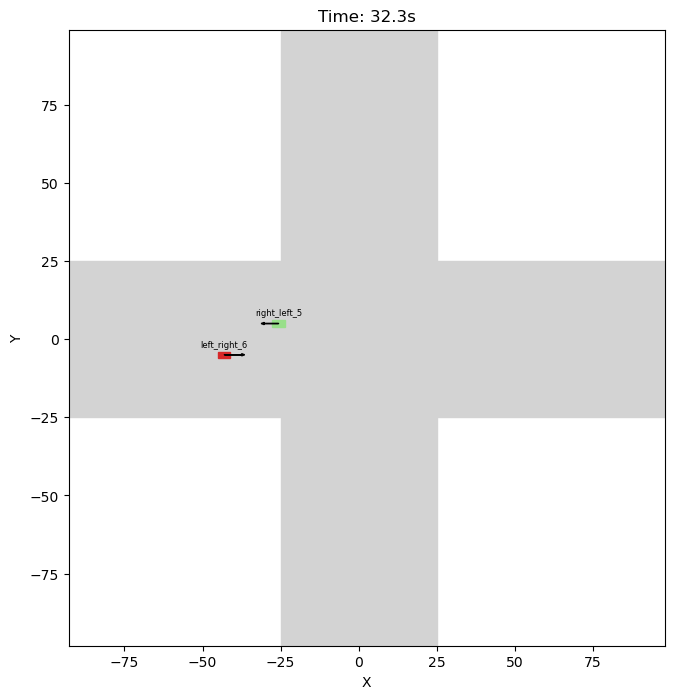

In [70]:
path_to_csv_data = r'csv/train_1k_simple_separate_10m'
output_video_name = "simple_separate_10m_intersection.mp4"

visualize_multiple_csvs_as_video(
    csv_folder=path_to_csv_data,
    output_video_path=output_video_name,
    interval_ms=100,
    max_frames=250  # optional lenght of the video in frames (None for all frames)
)


## Test inference with the model and visualize

In [3]:
import torch
from dataset import CarDataset
from model import GNN_mtl_gnn, GNN_mtl_mlp
from torch_geometric.loader import DataLoader

In [41]:
# ----- Settings -----
weights_path = "trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth"
data_folder  = "csv/train_pre_1k_simple_separate_10m"
batch_size   = 32           # change if you run out of memory
use_mlp      = False         # True for MLP, False for GNN
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")


# ----- Load model -----
model = GNN_mtl_mlp(hidden_channels=128).to(device) if use_mlp else GNN_mtl_gnn(hidden_channels=128).to(device)
state = torch.load(weights_path, map_location=device)
model.load_state_dict(state)
model.eval()

# ----- Load data -----
ds = CarDataset(preprocess_folder=data_folder, plot=True, mlp=use_mlp, mpc_aug=True)
loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

Running on: cuda


In [58]:
batch = next(iter(loader))

for i in range(len(batch)):
    print(batch[i])
    print(f"t: {batch[i].t}, edge_index: {batch[i].edge_index}, weights: {batch[i].weights}\n")



Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([0]), edge_index: tensor([[0],
        [0]]), weights: tensor([1.])

Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([0]), edge_index: tensor([[0],
        [0]]), weights: tensor([1.])

Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([0]), edge_index: tensor([[0],
        [0]]), weights: tensor([1.])

Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([0]), edge_index: tensor([[0],
        [0]]), weights: tensor([1.])

Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([1]), edge_index: tensor([[0],
        [0]]), weights: tensor([1.])

Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([1]), edge_index: tensor([[0],
        [0]]), weights: tensor([1.])

Data(x=[1, 7], edge_index=[2, 1], y=[1, 180], t=[1], weights=[1])
t: tensor([1]), edge_index: tensor([[0],
        [0]]), weights:

In [29]:
import math
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def visualize_prediction_video(
        pred_xy,                # (V, T, 2) tensor or ndarray – model output
        batch,                  # original DataBatch (needs x and yaw)
        dt=0.1,                 # time step used during training
        road_img=None,          # path or ndarray for background; None = blank
        output_path='prediction.mp4',
        interval_ms=200):
    """
    Make an MP4 showing the predicted motion of every vehicle.

    pred_xy : prediction for the next T frames, global coords.
    batch   : original PyG batch so we can get the start position, yaw, etc.
    """
    # -------- prepare data --------
    device = pred_xy.device if torch.is_tensor(pred_xy) else None
    pred_xy = pred_xy.cpu().numpy() if torch.is_tensor(pred_xy) else pred_xy
    init_xy = batch.x[:, 0:2].cpu().numpy()            # (V, 2)
    init_yaw = batch.x[:, 3].cpu().numpy()             # (V,)
    V, T, _ = pred_xy.shape

    # concat t0 + predictions  -> (V, T+1, 2)
    full_xy = np.concatenate([init_xy[:, None, :], pred_xy], axis=1)

    # speed and yaw over time
    step_vec = np.diff(full_xy, axis=1)                # (V, T, 2)
    speed = np.linalg.norm(step_vec, axis=-1) / dt     # (V, T)
    yaw = np.empty((V, T + 1))
    yaw[:, 0] = init_yaw
    yaw[:, 1:] = np.arctan2(step_vec[..., 1], step_vec[..., 0])

    # colours
    colours = [plt.cm.tab20(i % 20) for i in range(V)]

    # -------- figure --------
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.grid(False)

    if isinstance(road_img, str):
        road_img = plt.imread(road_img)
    if road_img is not None:
        # draw once; extent auto-scales to data range
        pad = 10
        extent = [
            full_xy[..., 0].min() - pad, full_xy[..., 0].max() + pad,
            full_xy[..., 1].min() - pad, full_xy[..., 1].max() + pad,
        ]
        ax.imshow(road_img, cmap="gray", origin="lower", extent=extent, alpha=0.7)

    pad = 10
    ax.set_xlim(full_xy[..., 0].min() - pad, full_xy[..., 0].max() + pad)
    ax.set_ylim(full_xy[..., 1].min() - pad, full_xy[..., 1].max() + pad)

    # rectangle + arrow for every car
    rects = [
        plt.Rectangle((0, 0), 4, 2, color=colours[i], zorder=2) for i in range(V)
    ]
    for r in rects:
        ax.add_patch(r)
    arrows = [ax.arrow(0, 0, 0, 0) for _ in range(V)]  # placeholders

    # -------- animation callbacks --------
    def init():
        return rects + arrows

    def update(frame):
        ax.set_title(f"t = {frame * dt:.1f} s")

        for i in range(V):
            # current position
            x, y = full_xy[i, frame]

            # ---- motion vector -------------------------------------------------
            if frame < T:                         # forward-diff except last frame
                dx = full_xy[i, frame + 1, 0] - x
                dy = full_xy[i, frame + 1, 1] - y
            else:                                 # backward-diff for last frame
                dx = x - full_xy[i, frame - 1, 0]
                dy = y - full_xy[i, frame - 1, 1]

            # if the car is stationary, keep previous heading
            if dx == dy == 0:
                heading = 0.0
            else:
                heading = math.atan2(dy, dx)      # radians, +x → 0

            # same conversion you used in the CSV visualiser
            heading_arrow = heading + math.pi / 2     # +90°
            heading_rect  = -heading_arrow            # flip for rectangle

            # ---- rectangle ----------------------------------------------------
            rects[i].set_xy((x - 2, y - 1))           # centre (4×2 m)
            rects[i].set_transform(
                Affine2D().rotate_around(x, y, heading_rect) + ax.transData
            )

            # ---- arrow --------------------------------------------------------
            arrows[i].remove()                        # erase old arrow
            v = math.hypot(dx, dy) / dt               # speed (m/s)
            arrow_len = min(v * 0.2, 10)              # scale
            arrows[i] = ax.arrow(
                x,
                y,
                -arrow_len * math.cos(heading_arrow),   # –cos, +sin
                 arrow_len * math.sin(heading_arrow),
                head_width=0.6,
                head_length=0.9,
                fc="black",
                ec="black",
                zorder=3,
            )

        return rects + arrows

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=T + 1,
        init_func=init,
        interval=interval_ms,
        blit=False,
    )
    ani.save(output_path, writer="ffmpeg", fps=max(1, 1000 // interval_ms))
    print(f"Saved {output_path}")

In [22]:
import numpy as np

def rotation_matrix_back(yaw: torch.Tensor) -> torch.Tensor:
    """
    Vectorised inverse rotation that turns local (+x fwd) coordinates
    back to the world frame (+y fwd).  yaw is shape (V,).
    Returns shape (V, 2, 2) on the same device & dtype.
    """
    # yaw already on GPU/CPU where batch.x lives
    c = torch.cos(yaw - math.pi / 2)   # cos(-π/2 + yaw)
    s = torch.sin(yaw - math.pi / 2)   # sin(-π/2 + yaw)

    # [[ c, -s],
    #  [ s,  c]]
    R = torch.stack(
        (
            torch.stack((c, -s), dim=-1),
            torch.stack((s,  c), dim=-1)
        ),
        dim=-2
    )                                   # (V, 2, 2)
    return R

def run_model(b):
    out = model(b.x[:, [0, 1, 4, 5, 6]], b.edge_index)  # (V, 60)
    out = out.view(-1, 30, 2).permute(0, 2, 1)          # (V, 2, 30)

    R = rotation_matrix_back(b.x[:, 3])                 # (V, 2, 2)
    out = torch.bmm(R, out).permute(0, 2, 1)            # (V, 30, 2)
    out += b.x[:, 0:2].unsqueeze(1)                     # translate
    return out                                          # (V, 30, 2)

Saved model_prediction.mp4


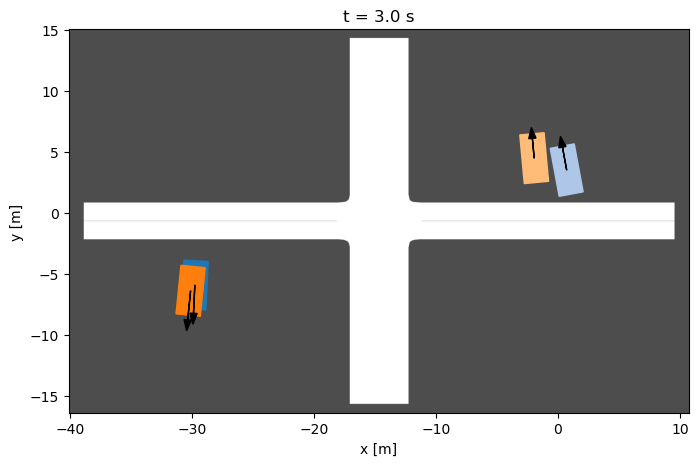

In [30]:
with torch.no_grad():
    for batch in loader:
        batch = batch.to(device)
        pred = run_model(batch)               # (V, 30, 2)  from the notebook
    visualize_prediction_video(
        pred_xy=pred,
        batch=batch,
        dt=0.1,               # step from utils.config
        road_img="map_binary_images/simple_separate_10m_binary.png",    # or None
        output_path="model_prediction.mp4",
        interval_ms=200                       # slow playback
    )

In [40]:
batch

DataBatch(x=[4, 7], edge_index=[2, 8], y=[4, 180], t=[2], weights=[4], batch=[4], ptr=[3])

In [ ]:
# ----- Run inference -----
with torch.no_grad():
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x[:,[0,1,4,5,6]], batch.edge_index)


Batch: 0 | Output: tensor([[ 1.1219e-03,  1.3615e+00, -1.3084e-01,  2.6196e+00, -7.0947e-02,
          3.9292e+00, -2.0078e-02,  5.2266e+00, -2.5319e-01,  6.5760e+00,
         -2.2992e-01,  8.0194e+00, -2.6077e-01,  9.1941e+00, -2.4451e-01,
          1.0549e+01, -2.1842e-01,  1.2083e+01, -3.2540e-01,  1.3110e+01,
         -1.7146e-01,  1.4460e+01, -1.9537e-01,  1.5843e+01, -1.8183e-01,
          1.7165e+01, -1.1265e-01,  1.8479e+01, -6.2896e-02,  1.9721e+01,
         -1.7830e-01,  2.1237e+01, -1.6239e-01,  2.2530e+01, -2.6694e-01,
          2.3627e+01, -2.8509e-01,  2.5239e+01, -1.8421e-01,  2.6255e+01,
         -4.3685e-01,  2.7451e+01, -1.9585e-01,  2.9062e+01, -4.2109e-01,
          3.0289e+01, -5.5574e-02,  3.1402e+01, -3.9671e-01,  3.2833e+01,
         -4.5108e-01,  3.3950e+01, -4.1101e-01,  3.5111e+01, -4.8319e-01,
          3.6381e+01, -4.5654e-01,  3.7577e+01, -5.8554e-01,  3.8730e+01],
        [-3.9813e-03,  1.4139e+00, -1.1387e-02,  2.7433e+00,  1.8705e-01,
          4.0498e+

In [6]:
out.shape

torch.Size([4, 60])

In [9]:
import torch
from torch_geometric.data import Data
import numpy as np

def build_graph_for_frame(frame_df):
    xs   = frame_df["X"].astype(float).to_numpy()
    ys   = frame_df["Y"].astype(float).to_numpy()
    vs   = frame_df["speed"].astype(float).to_numpy()
    yaws = frame_df["yaw"].astype(float).to_numpy()

    if {"intent_0","intent_1","intent_2"}.issubset(frame_df.columns):
        i0 = frame_df["intent_0"].astype(float).to_numpy()
        i1 = frame_df["intent_1"].astype(float).to_numpy()
        i2 = frame_df["intent_2"].astype(float).to_numpy()
    else:
        N = len(frame_df)
        i0 = np.zeros(N, dtype=float)
        i1 = np.zeros(N, dtype=float)
        i2 = np.zeros(N, dtype=float)

    x = torch.from_numpy(
        np.stack([xs, ys, vs, yaws, i0, i1, i2], axis=1)
    ).float()

    N = x.size(0)
    row, col = [], []
    for i in range(N):
        for j in range(N):
            if i != j:
                row.append(i)
                col.append(j)
    edge_index = torch.tensor([row, col], dtype=torch.long)

    track_ids = frame_df["TRACK_ID"].tolist()
    t       = torch.tensor([float(frame_df["TIMESTAMP"].iloc[0])])
    weights = torch.ones(N, dtype=torch.float)

    d = Data(x=x, edge_index=edge_index, t=t, weights=weights)
    d.track_ids = track_ids
    return d

def get_neighbors(frame_df, track_id, radius=30.0):
    center = frame_df[frame_df["TRACK_ID"] == track_id]
    if center.empty:
        return frame_df
    cx, cy = center[["X","Y"]].astype(float).iloc[0]
    d2 = (frame_df["X"].astype(float) - cx)**2 + (frame_df["Y"].astype(float) - cy)**2
    return frame_df[d2 <= radius**2]

Saved to intersection.mp4


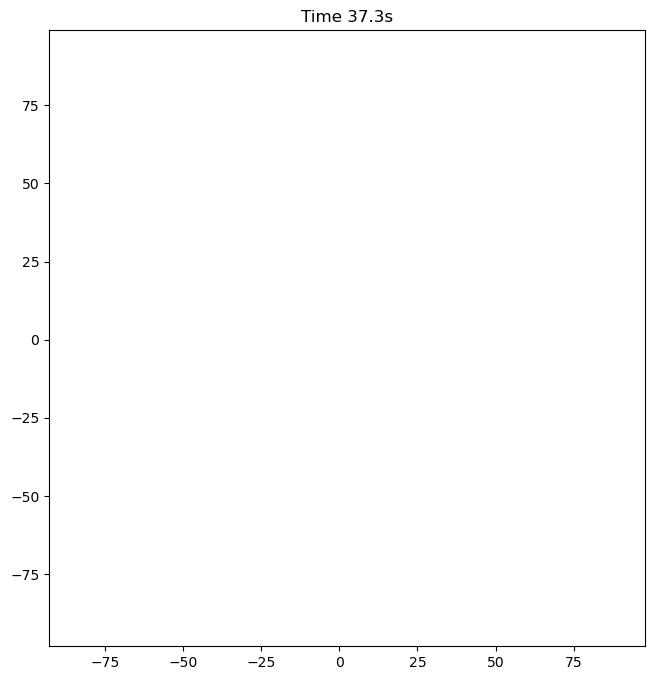

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from glob import glob
import os
from utils.config import OBS_LEN, PRED_LEN

# --- load your trained model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN_mtl_gnn(hidden_channels=128).to(device)
model.load_state_dict(torch.load("trained_params_archive/sumo_with_mpc_online_control/model_rot_gnn_mtl_np_sumo_0911_e3_1930.pth", map_location=device))
model.eval()

# how many steps your model predicts 
pred_len = PRED_LEN  # how many frames to show real data before prediction

# --- visualize function ---

def visualize(csv_folder,
              output_video="intersection.mp4",
              interval_ms=100,
              max_frames=None):

    all_csvs = sorted(glob(os.path.join(csv_folder, "*.csv")))
    df = pd.concat([pd.read_csv(p) for p in all_csvs])
    df = df.sort_values("TIMESTAMP")
    timestamps = sorted(df["TIMESTAMP"].unique())
    if max_frames:
        timestamps = timestamps[:max_frames]

    grouped = df.groupby("TIMESTAMP")
    predictions = {}

    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_aspect("equal")
    x_min, x_max = df["X"].min()-10, df["X"].max()+10
    y_min, y_max = df["Y"].min()-10, df["Y"].max()+10

    def init():
        return []

    def update(frame_idx):
        ts = timestamps[frame_idx]
        ax.clear()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_title(f"Time {ts:.1f}s")

        frame_df = grouped.get_group(ts) if ts in grouped.groups else pd.DataFrame()

        # predict for new cars
        for _, row in frame_df.iterrows():
            tid = row["TRACK_ID"]
            if tid not in predictions:
                sub_df = get_neighbors(frame_df, tid, radius=30.0)
                data   = build_graph_for_frame(sub_df)

                feat = data.x[:, [0,1,4,5,6]].to(device)
                edge = data.edge_index.to(device)
                with torch.no_grad():
                    out = model(feat, edge)

                out = out.cpu().numpy().reshape(-1, pred_len, 2)
                idx  = data.track_ids.index(tid)
                preds = out[idx]

                predictions[tid] = {
                    "start_idx": frame_idx,
                    "preds": preds
                }

        # determine which cars to draw
        real_ids = set(frame_df["TRACK_ID"])
        pred_ids = {
            tid for tid, rec in predictions.items()
            if 0 <= (frame_idx - rec["start_idx"]) < pred_len
        }
        active_ids = real_ids.union(pred_ids)

        for tid in active_ids:
            rec    = predictions.get(tid, None)
            seen   = frame_idx - (rec["start_idx"] if rec else 0)

            # draw real for first OBS_LEN frames
            if tid in real_ids and seen < OBS_LEN:
                sub = frame_df[frame_df["TRACK_ID"] == tid]
                x, y, yaw, speed = sub.iloc[0][["X","Y","yaw","speed"]]
            elif rec and 0 <= seen < pred_len:
                x, y = rec["preds"][seen]
                # reuse last known yaw/speed
                past = df[(df["TRACK_ID"]==tid)&(df["TIMESTAMP"]<=ts)]
                yaw   = float(past.iloc[-1]["yaw"])
                speed = float(past.iloc[-1]["speed"])
            else:
                continue

            # draw road
            rw = 50
            ax.add_patch(plt.Rectangle((x_min, -rw/2),
                                       x_max-x_min, rw,
                                       color="lightgray", zorder=0))
            ax.add_patch(plt.Rectangle((-rw/2, y_min),
                                       rw, y_max-y_min,
                                       color="lightgray", zorder=0))

            # draw car rectangle
            length, width = 4, 2
            theta = np.deg2rad(yaw + 90)
            dx, dy = -length/2, -width/2
            rect = plt.Rectangle((x+dx, y+dy), length, width,
                                 color="C0", zorder=1)
            tr = (plt.matplotlib.transforms.Affine2D()
                  .rotate_around(x, y, -theta) + ax.transData)
            rect.set_transform(tr)
            ax.add_patch(rect)

            # draw speed arrow
            arrow_len = min(speed*0.4, 10)
            ax.arrow(x, y,
                     -arrow_len*np.cos(theta),
                     arrow_len*np.sin(theta),
                     head_width=0.7, head_length=1,
                     fc="k", ec="k", zorder=2)

            ax.text(x, y+2.5, str(tid),
                    fontsize=6, ha="center", zorder=3)
        return []

    ani = animation.FuncAnimation(
        fig, update,
        frames=len(timestamps),
        init_func=init,
        interval=interval_ms,
        blit=False
    )
    ani.save(output_video, writer="ffmpeg", fps=1000//interval_ms)
    print("Saved to", output_video)

# Example usage
csv_folder = 'csv/train_1k_simple_separate_10m'
output_video_path = 'intersection.mp4'
visualize(csv_folder, output_video=output_video_path, interval_ms=100, max_frames=300)